In [104]:
import pandas as pd

# Cargar archivos
cobros = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/ListaCobroDetalleUnido.csv")
estrategias = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/ListaCobroEmisora.csv")
respuestas = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/CatRespuestaBancos.csv")

# Enriquecer con estrategia usada
cobros = cobros.merge(estrategias, on="idListaCobro", how="left")

# Enriquecer con descripción de respuesta del banco
cobros = cobros.merge(respuestas, left_on="idRespuestaBanco", right_on="IdRespuestaBanco", how="left")

# Marcar si fue exitoso
cobros["esExitoso"] = cobros["idRespuestaBanco"] == "00"

# Clasificar respuesta en categorías generales
def clasificar_respuesta(row):
    if row["idRespuestaBanco"] == "00":
        return "exitosa"
    elif row["Descripcion"] in ["Cuenta Cancelada", "Cuenta Bloqueada", "Cuenta Inexistente"]:
        return "cuenta_invalida"
    else:
        return "otros"

cobros["respuestaCategoria"] = cobros.apply(clasificar_respuesta, axis=1)

# Sort por esExitoso True 
cobros = cobros.sort_values(by=["esExitoso", "idListaCobro", "idRespuestaBanco"], ascending=[False, True, True])

cobros.head()


/var/folders/nq/zht86vzj6n5g3py55h5xd7xr0000gn/T/ipykernel_16526/505670164.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  cobros = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/ListaCobroDetalleUnido.csv")


,idListaCobro,idCredito,consecutivoCobro,idBanco,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,idRespuestaBanco,idEmisora,IdRespuestaBanco,Descripcion,esExitoso,respuestaCategoria
52431,79678,291172,23794381,44,275.50,275.50,275.50,04/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa
52327,80111,459208,23840286,21,720.36,720.36,720.36,11/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa
52340,80111,495309,23840297,21,225.87,225.87,225.87,11/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa
52345,80111,507710,23840301,21,833.37,833.37,833.37,11/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa
52353,80111,525580,23840309,21,483.91,483.91,483.91,11/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa


In [105]:
print(cobros.shape)
# Drop columnas innecesarias: idListaCobro, fechaCobroBanco, IdRespuestaBanco
cobros.drop(columns=["idListaCobro", "fechaCobroBanco", "IdRespuestaBanco"], inplace=True)
# Drop NaN values
cobros.dropna(subset=["idRespuestaBanco"], inplace=True)
print(cobros.shape)

(10057440, 14)
(9907879, 11)


In [106]:
#  mostrar valores unicos en idEmisora
print(cobros["idEmisora"].unique())

[20 19 68 78 25 21 23 24 34  1 36 51 79 62 75 16 45  2  4 10 13 12  9  6
  5 17 11 15 14 22 18  3  7]


In [107]:
# Cargar tabla de costos por estrategia
costos = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/CatEmisora.csv")

# Asegurarse de que los nombres de columnas están bien
costos.columns = costos.columns.str.strip()  # quitar espacios accidentales
costos["cobraSoloExitoso"] = costos["cobraSoloExitoso"].astype(bool)

# Unir al dataframe de cobros por 'idEmisora'
cobros = cobros.merge(costos[["idEmisora", "costo", "cobraSoloExitoso"]], on="idEmisora", how="left")

# Calcular el costo real de cada intento según si se cobra solo por éxito o siempre
def calcular_costo_transaccion(row):
    if row["cobraSoloExitoso"]:
        return row["costo"] if row["esExitoso"] else 0
    else:
        return row["costo"]

cobros["costoTransaccion"] = cobros.apply(calcular_costo_transaccion, axis=1)


In [108]:
# mostrar entradas con idEmidora = 62
print(cobros[cobros["idEmisora"] == 1].shape)

cobros[cobros["idEmisora"] == 1].head()


(654165, 14)


,idCredito,consecutivoCobro,idBanco,montoExigible,montoCobrar,montoCobrado,idRespuestaBanco,idEmisora,Descripcion,esExitoso,respuestaCategoria,costo,cobraSoloExitoso,costoTransaccion
800,496166,25100980,12,2213.32,2213.32,2213.32,00,1,Domiciliacion Exitosa,True,exitosa,1.75,False,1.75
801,498161,25100981,12,4249.57,4249.57,4249.57,00,1,Domiciliacion Exitosa,True,exitosa,1.75,False,1.75
29315,502609,25100982,12,4735.46,4735.46,0.00,DD00031,1,Cuenta con Insuficiencia de Fondos,False,otros,1.75,False,1.75
29316,511266,25100983,12,2652.84,2652.84,0.00,DD00031,1,Cuenta con Insuficiencia de Fondos,False,otros,1.75,False,1.75
1327224,678562,33345778,2,400.00,400.00,0.00,4.0,1,NaN,False,otros,1.75,False,1.75


In [109]:
idEmisora = cobros["idEmisora"].unique()
# Contar cuantos diferents idBanco tiene cada idEmisora
idBanco_counts = cobros.groupby("idEmisora")["idBanco"].nunique().reset_index()

idBanco_counts.head(50)

,idEmisora,idBanco
0,1,2
1,2,1
2,3,1
3,4,1
4,5,1
5,6,12
6,7,2
7,9,1
8,10,1
9,11,1


In [110]:
# Ordenar por crédito y consecutivoCobro
cobros = cobros.sort_values(by=["idCredito", "consecutivoCobro"])

# Calcular número de intento por crédito
cobros["num_intento"] = cobros.groupby("idCredito").cumcount() + 1
cobros["es_segundo_intento"] = cobros["num_intento"] == 2
cobros["num_exitos_previos"] = cobros.groupby("idCredito")["esExitoso"].cumsum() - cobros["esExitoso"].astype(int)
cobros["num_intentos_previos"] = cobros["num_intento"] - 1

cobros.head()

,idCredito,consecutivoCobro,idBanco,montoExigible,montoCobrar,montoCobrado,idRespuestaBanco,idEmisora,Descripcion,esExitoso,respuestaCategoria,costo,cobraSoloExitoso,costoTransaccion,num_intento,es_segundo_intento,num_exitos_previos,num_intentos_previos
1168226,6,32697369,2,375.47,375.47,0.0,4.0,23,NaN,False,otros,1.91,True,0.0,1,False,0,0
4012338,3674,36776754,72,344.18,344.18,0.0,1.0,12,NaN,False,otros,2.50,False,2.5,1,False,0,0
39374,4635,27248919,72,160.13,160.13,0.0,04,25,Cuenta Insuficiencia Fondos,False,otros,6.00,True,0.0,1,False,0,0
53084,4635,29393671,72,160.13,160.13,0.0,04,25,Cuenta Insuficiencia Fondos,False,otros,6.00,True,0.0,2,True,0,1
112842,4635,29600474,72,160.13,160.13,0.0,04,25,Cuenta Insuficiencia Fondos,False,otros,6.00,True,0.0,3,False,0,2


In [111]:
# Proporcion de intentos exitosos segun columna esExitoso 
exitosos = cobros[cobros["esExitoso"] == True]
fallidos = cobros[cobros["esExitoso"] == False]
print("Proporción de intentos exitosos:", len(exitosos) / (len(exitosos) + len(fallidos)))



Proporción de intentos exitosos: 0.001886377498150714


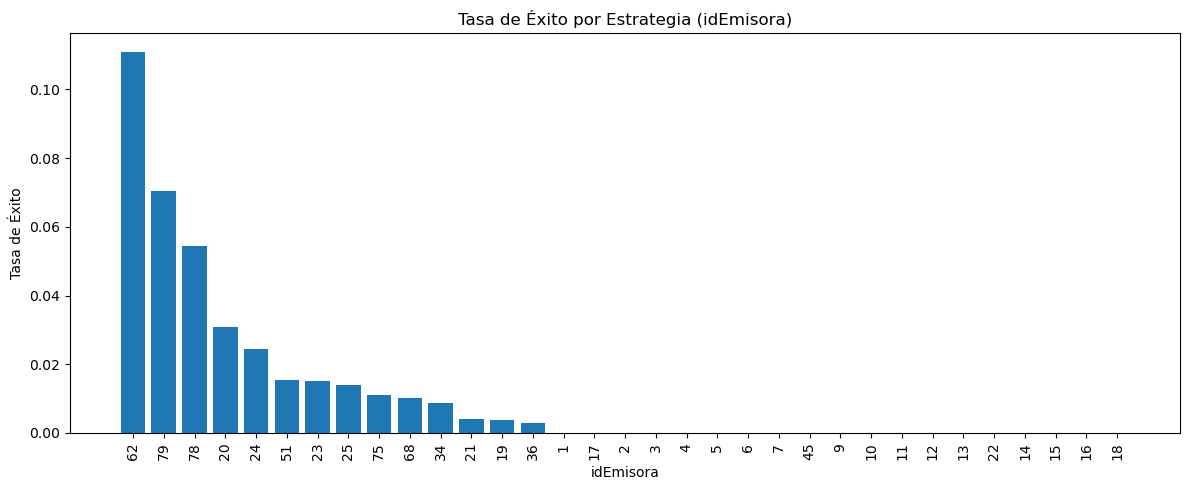

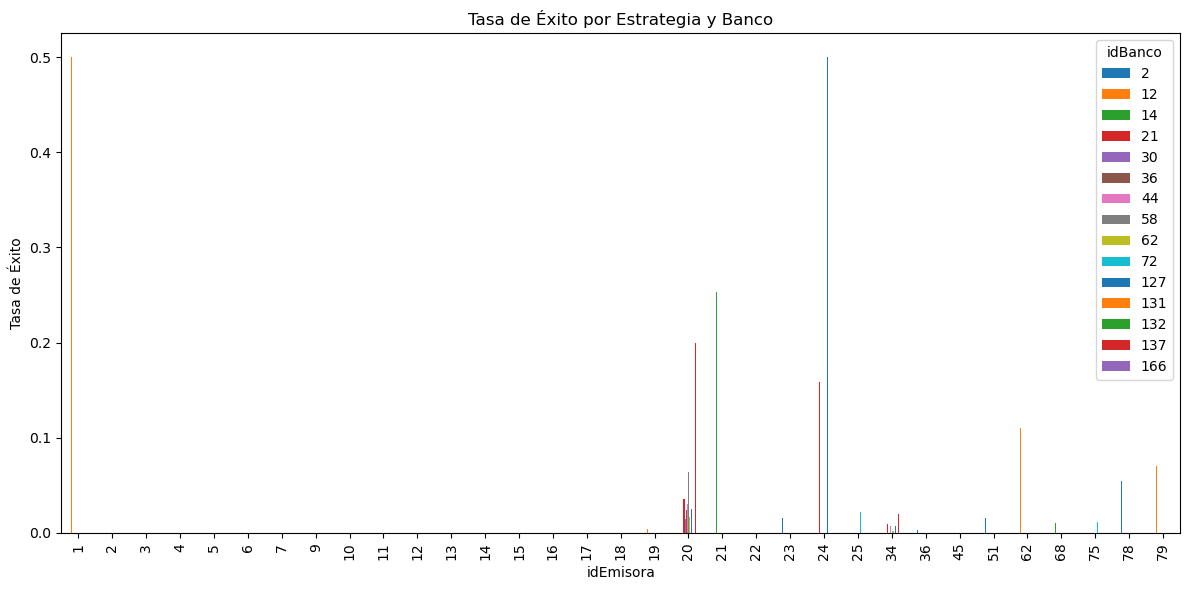

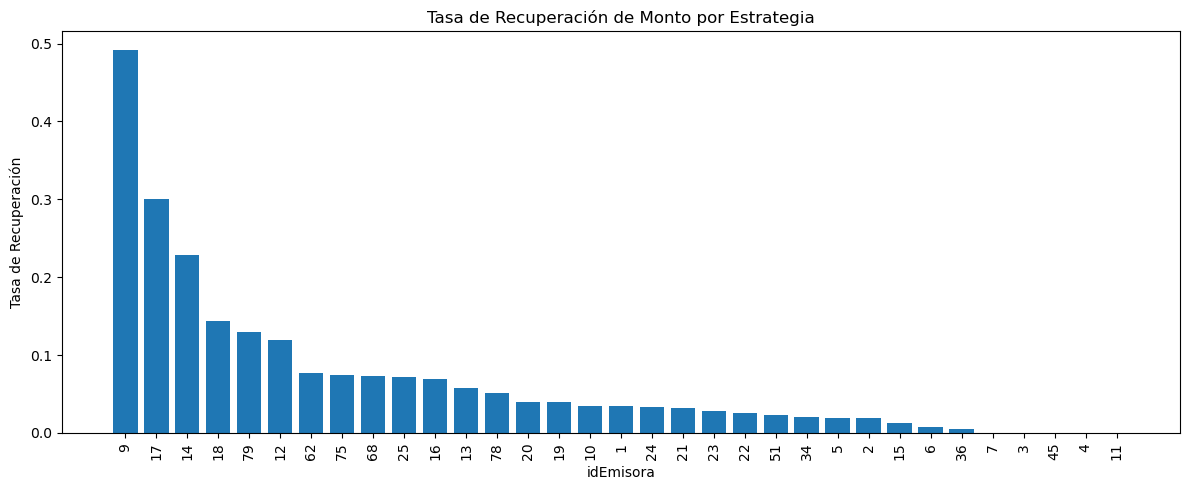

Tasa de éxito en el segundo intento: 3.93%

Distribución de respuestas del banco en segundo intento:
respuestaCategoria
otros              0.947812
exitosa            0.039311
cuenta_invalida    0.012877
Name: proportion, dtype: float64


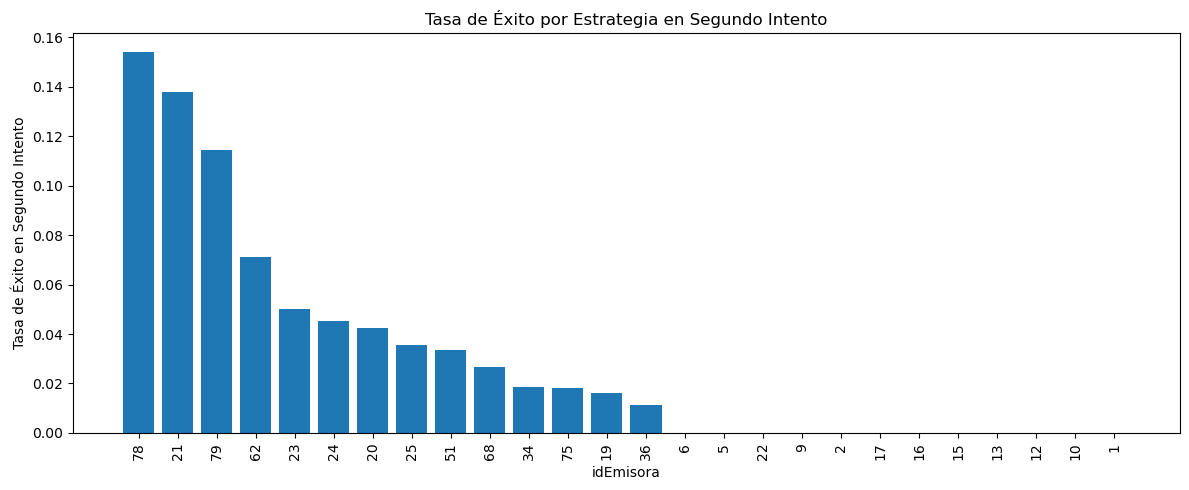

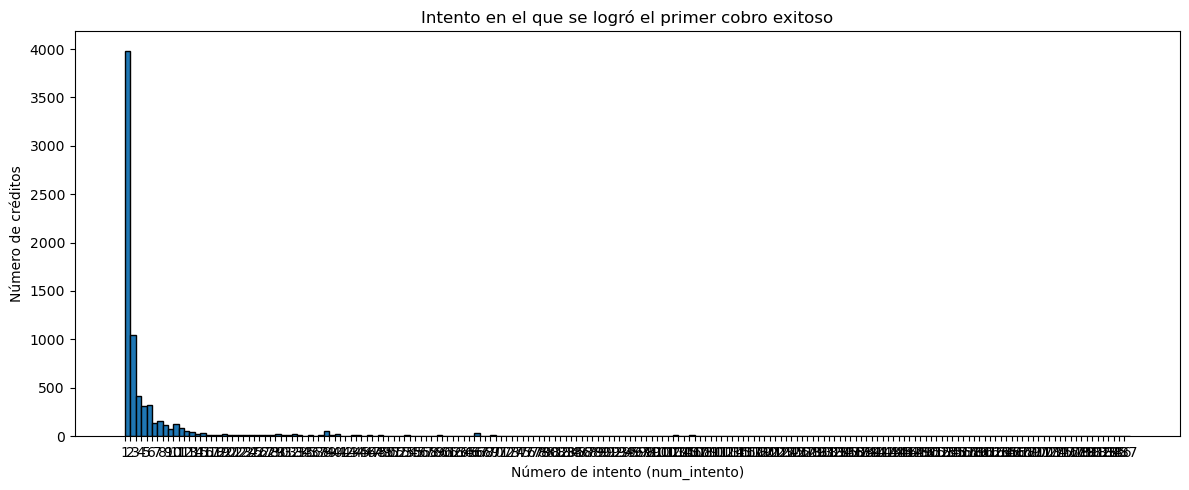

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegúrate de que `cobros` esté cargado y contenga estas columnas:
# idEmisora, idBanco, montoExigible, montoCobrado, esExitoso

# === 1. Tasa de Éxito por Estrategia (idEmisora) ===
exito_por_estrategia = cobros.groupby("idEmisora")["esExitoso"].agg(["count", "sum"])
exito_por_estrategia["tasa_exito"] = exito_por_estrategia["sum"] / exito_por_estrategia["count"]
exito_por_estrategia = exito_por_estrategia.sort_values("tasa_exito", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(exito_por_estrategia.index.astype(str), exito_por_estrategia["tasa_exito"])
plt.title("Tasa de Éxito por Estrategia (idEmisora)")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Éxito")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# === 2. Tasa de Éxito por Banco y Estrategia ===
exito_banco_estrategia = cobros.groupby(["idBanco", "idEmisora"])["esExitoso"].agg(["count", "sum"])
exito_banco_estrategia["tasa_exito"] = exito_banco_estrategia["sum"] / exito_banco_estrategia["count"]
pivot_be = exito_banco_estrategia.reset_index().pivot(index="idEmisora", columns="idBanco", values="tasa_exito")

pivot_be.plot(kind="bar", figsize=(12, 6))
plt.title("Tasa de Éxito por Estrategia y Banco")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Éxito")
plt.xticks(rotation=90)
plt.legend(title="idBanco")
plt.tight_layout()
plt.show()

# === 3. Tasa de Recuperación de Monto por Estrategia ===
monto_estrategia = cobros.groupby("idEmisora")[["montoExigible", "montoCobrado"]].sum()
monto_estrategia["tasa_recuperacion"] = monto_estrategia["montoCobrado"] / monto_estrategia["montoExigible"]
monto_estrategia = monto_estrategia.sort_values("tasa_recuperacion", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(monto_estrategia.index.astype(str), monto_estrategia["tasa_recuperacion"])
plt.title("Tasa de Recuperación de Monto por Estrategia")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Recuperación")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# %%
# === 4. Análisis de SEGUNDO intento de cobranza ===
segundos = cobros[cobros["es_segundo_intento"] == True]

# Tasa de éxito en el segundo intento
tasa_exito_segundo = segundos["esExitoso"].mean()
print(f"Tasa de éxito en el segundo intento: {tasa_exito_segundo:.2%}")

# Distribución de respuestas en segundo intento
print("\nDistribución de respuestas del banco en segundo intento:")
print(segundos["respuestaCategoria"].value_counts(normalize=True))

# Comparar estrategias más comunes en segundo intento
estrategias_segundo = segundos.groupby("idEmisora")["esExitoso"].agg(["count", "sum"])
estrategias_segundo["tasa_exito"] = estrategias_segundo["sum"] / estrategias_segundo["count"]
estrategias_segundo = estrategias_segundo.sort_values("tasa_exito", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(estrategias_segundo.index.astype(str), estrategias_segundo["tasa_exito"])
plt.title("Tasa de Éxito por Estrategia en Segundo Intento")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Éxito en Segundo Intento")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# %%
# === 5. Análisis de intentos acumulados antes de éxito ===
# Solo intentos exitosos
exitos = cobros[cobros["esExitoso"] == True]

# Para cada crédito exitoso, ¿en qué intento lo logró?
primer_exito = exitos.groupby("idCredito")["num_intento"].min()

plt.figure(figsize=(12, 5))
plt.hist(primer_exito, bins=range(1, primer_exito.max()+2), edgecolor='black')
plt.title("Intento en el que se logró el primer cobro exitoso")
plt.xlabel("Número de intento (num_intento)")
plt.ylabel("Número de créditos")
plt.xticks(range(1, primer_exito.max()+1))
plt.tight_layout()
plt.show()


In [115]:
# %%
# Agrupar métricas por estrategia
estrategias_eval = cobros.groupby("idEmisora").agg(
    total_intentos=("idCredito", "count"),
    total_exitos=("esExitoso", "sum"),
    monto_total_cobrado=("montoCobrado", "sum"),
    costo_total=("costoTransaccion", "sum")
)

# Métricas adicionales
estrategias_eval["tasa_exito"] = estrategias_eval["total_exitos"] / estrategias_eval["total_intentos"]
estrategias_eval["roi"] = estrategias_eval["monto_total_cobrado"] / estrategias_eval["costo_total"]
estrategias_eval["efectividad_ajustada"] = (estrategias_eval["monto_total_cobrado"] - estrategias_eval["costo_total"]) / estrategias_eval["total_intentos"]

estrategias_eval = estrategias_eval.sort_values("efectividad_ajustada", ascending=False)
estrategias_eval.reset_index(inplace=True)

# Mostrar top 10 estrategias
estrategias_eval.head(50)


,idEmisora,total_intentos,total_exitos,monto_total_cobrado,costo_total,tasa_exito,roi,efectividad_ajustada
0,14,20,0,7176.05,90.00,0.000000,79.733889,354.302500
1,9,125829,0,37746119.43,354837.78,0.000000,106.375706,297.159491
2,17,222739,0,46906100.02,0.00,0.000000,inf,210.587728
3,78,368,20,51895.60,644.00,0.054348,80.583230,139.270652
4,79,61892,4365,7866147.81,34920.00,0.070526,225.261965,126.530534
5,12,160604,0,16982801.02,401510.00,0.000000,42.297330,103.243325
6,18,18304,0,1586420.99,0.00,0.000000,inf,86.670727
7,25,104967,1479,8767382.30,8874.00,0.014090,987.985384,83.440589
8,62,4829,535,272046.47,1021.85,0.110789,266.229359,56.124378
9,68,102288,1053,5106113.87,288452.16,0.010294,17.701770,47.098992


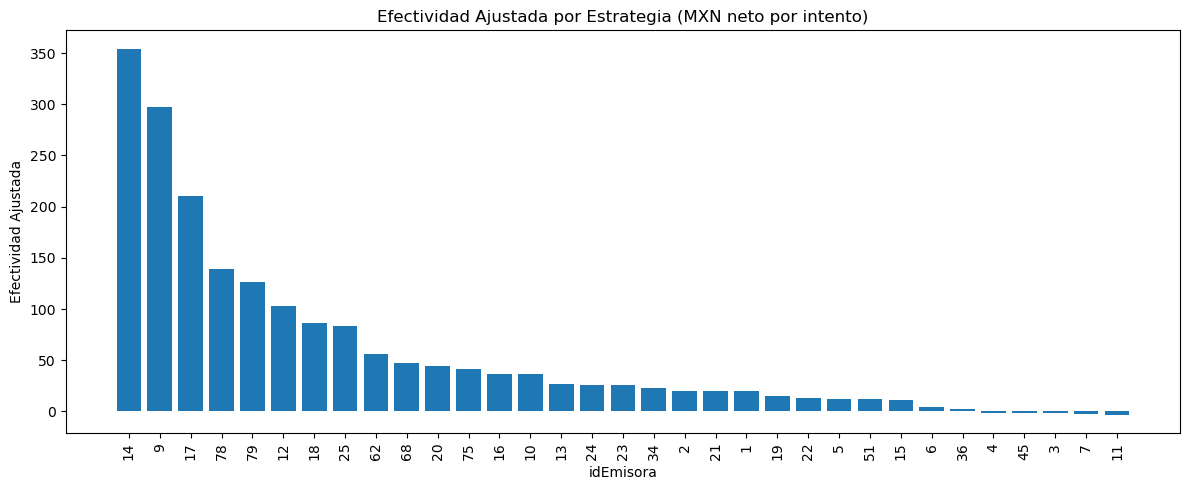

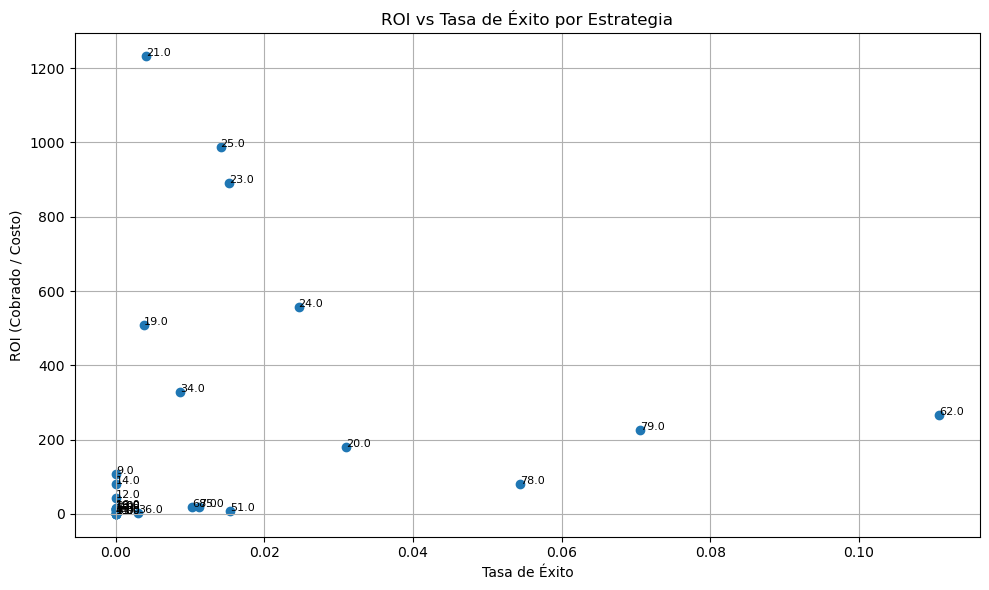

In [114]:
# %%
# Gráfico: Efectividad ajustada
plt.figure(figsize=(12, 5))
plt.bar(estrategias_eval["idEmisora"].astype(str), estrategias_eval["efectividad_ajustada"])
plt.title("Efectividad Ajustada por Estrategia (MXN neto por intento)")
plt.xlabel("idEmisora")
plt.ylabel("Efectividad Ajustada")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Gráfico: ROI vs Tasa de Éxito
plt.figure(figsize=(10, 6))
plt.scatter(estrategias_eval["tasa_exito"], estrategias_eval["roi"])
for i, row in estrategias_eval.iterrows():
    plt.text(row["tasa_exito"], row["roi"], str(row["idEmisora"]), fontsize=8)
plt.xlabel("Tasa de Éxito")
plt.ylabel("ROI (Cobrado / Costo)")
plt.title("ROI vs Tasa de Éxito por Estrategia")
plt.grid(True)
plt.tight_layout()
plt.show()



=== Classification Report (con class_weight='balanced') ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2966757
           1       0.92      0.80      0.86      5607

    accuracy                           1.00   2972364
   macro avg       0.96      0.90      0.93   2972364
weighted avg       1.00      1.00      1.00   2972364

AUC: 0.9352


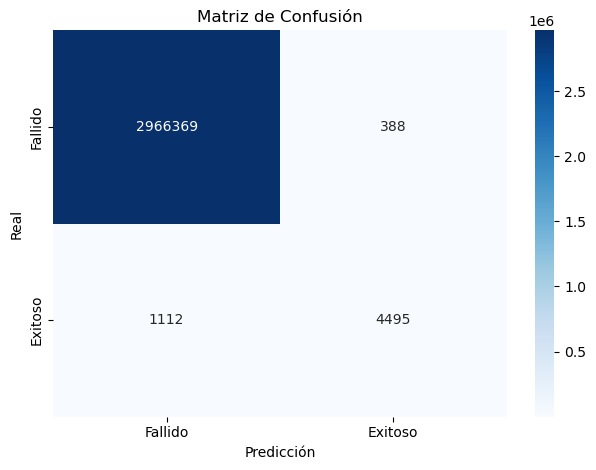

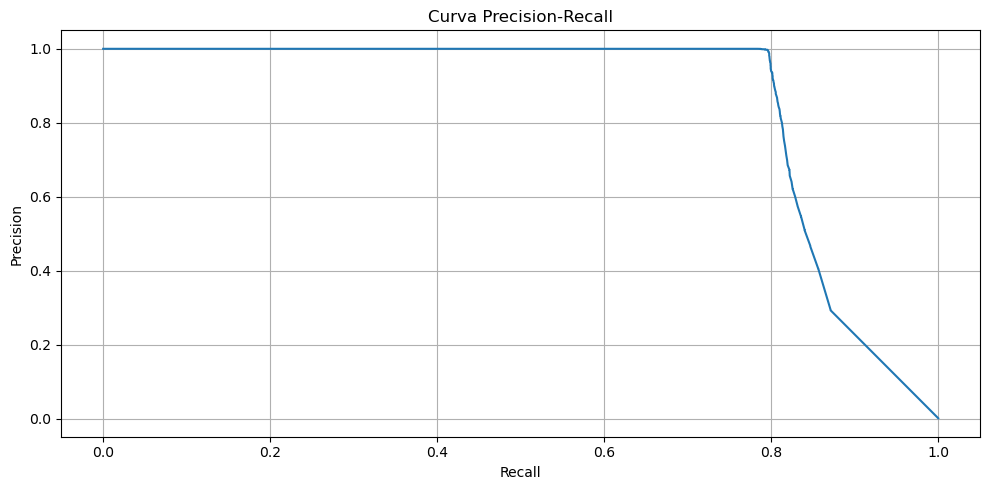

In [116]:
# %%
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Variables para el modelo, incluyendo información financiera
vars_modelo = [
    "idBanco", "idEmisora", "montoExigible", "montoCobrar",
    "num_intentos_previos", "num_exitos_previos", "es_segundo_intento",
    "costoTransaccion", "cobraSoloExitoso"
]

# Preparar X e y
X = cobros[vars_modelo]
y = cobros["esExitoso"].astype(int)

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=["idBanco", "idEmisora", "cobraSoloExitoso"])

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Modelo con ajuste por desbalance
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# === Evaluación ===
print("\n=== Classification Report (con class_weight='balanced') ===")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fallido", "Exitoso"], yticklabels=["Fallido", "Exitoso"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === Curva de precisión vs recall ===
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.grid(True)
plt.tight_layout()
plt.show()
